In [31]:
!pip install git+https://github.com/wiktorlazarski/head-segmentation.git

  Cloning https://github.com/wiktorlazarski/head-segmentation.git to /tmp/pip-req-build-adoc93g1
  Running command git clone --filter=blob:none --quiet https://github.com/wiktorlazarski/head-segmentation.git /tmp/pip-req-build-adoc93g1
  Resolved https://github.com/wiktorlazarski/head-segmentation.git to commit 78121bdf40752754179c53bf28b785a671c5aecc
^C
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
import head_segmentation.segmentation_pipeline as seg_pipeline
from tqdm import tqdm

In [33]:
# Dataset class to load images
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [34]:
def segment_and_save_images(input_folder, output_folder, device):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    segmentation_pipeline = seg_pipeline.HumanHeadSegmentationPipeline(device=device)

    for img_name in tqdm(os.listdir(input_folder), desc="Segmenting Images"):
        if img_name.endswith('.jpg') or img_name.endswith('.png'):
            img_path = os.path.join(input_folder, img_name)
            save_path = os.path.join(output_folder, img_name)

            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            segmentation_map = segmentation_pipeline.predict(image_rgb)
            segmented_region = image_rgb * cv2.cvtColor(segmentation_map, cv2.COLOR_GRAY2RGB)

            pil_image = Image.fromarray(segmented_region.astype('uint8'))
            pil_image.save(save_path)

In [35]:
# Paths and hyperparameters
input_folder_path = '/kaggle/input/deepfake/DFWILD/train_real'
segmented_folder_path = '/kaggle/working/segmented_images'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
use_segmented = False

In [37]:
if use_segmented:
    # Segment and save images
    segment_and_save_images(input_folder_path, segmented_folder_path, device)

In [38]:
folder_path = segmented_folder_path if use_segmented else input_folder_path

In [39]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [40]:
dataset = ImageDataset(folder_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [41]:
# Define the Sparse Autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 32 * 32, bottleneck_size),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 256 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (256, 32, 32)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [42]:
# L1 regularization for sparsity
def l1_regularization(model, lambda_l1):
    l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    return lambda_l1 * l1_norm

In [43]:
def train_autoencoder(data_loader, model, criterion, optimizer, epochs, device, lambda_l1, visualize=True):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for images in tqdm(data_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss += l1_regularization(model, lambda_l1)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(data_loader):.4f}")
        if visualize:
            visualize_reconstruction(model, data_loader, device)

In [44]:
# Visualization of original and reconstructed images
def visualize_reconstruction(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            outputs = model(images)
            images = images.cpu()
            outputs = outputs.cpu()

            # Select 8 random images from the batch
            indices = random.sample(range(len(images)), 8)
            selected_images = images[indices]
            selected_outputs = outputs[indices]

            # Plot original and reconstructed images in a 4x4 grid
            fig, axes = plt.subplots(4, 4, figsize=(12, 12))
            for i in range(8):
                # Original images
                axes[2 * (i // 4), i % 4].imshow(selected_images[i].permute(1, 2, 0).numpy())
                axes[2 * (i // 4), i % 4].axis('off')
                axes[2 * (i // 4), i % 4].set_title("Original")

                # Reconstructed images
                axes[2 * (i // 4) + 1, i % 4].imshow(selected_outputs[i].permute(1, 2, 0).numpy())
                axes[2 * (i // 4) + 1, i % 4].axis('off')
                axes[2 * (i // 4) + 1, i % 4].set_title("Reconstructed")

            plt.tight_layout()
            plt.show()
            break  # Only visualize one batch


In [45]:
# Model, loss function, and optimizer
bottleneck_size = 1024
model = SparseAutoencoder(bottleneck_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [46]:
model.eval()

SparseAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=262144, out_features=1024, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=262144, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 32, 32))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Sigmoid()
  )
)

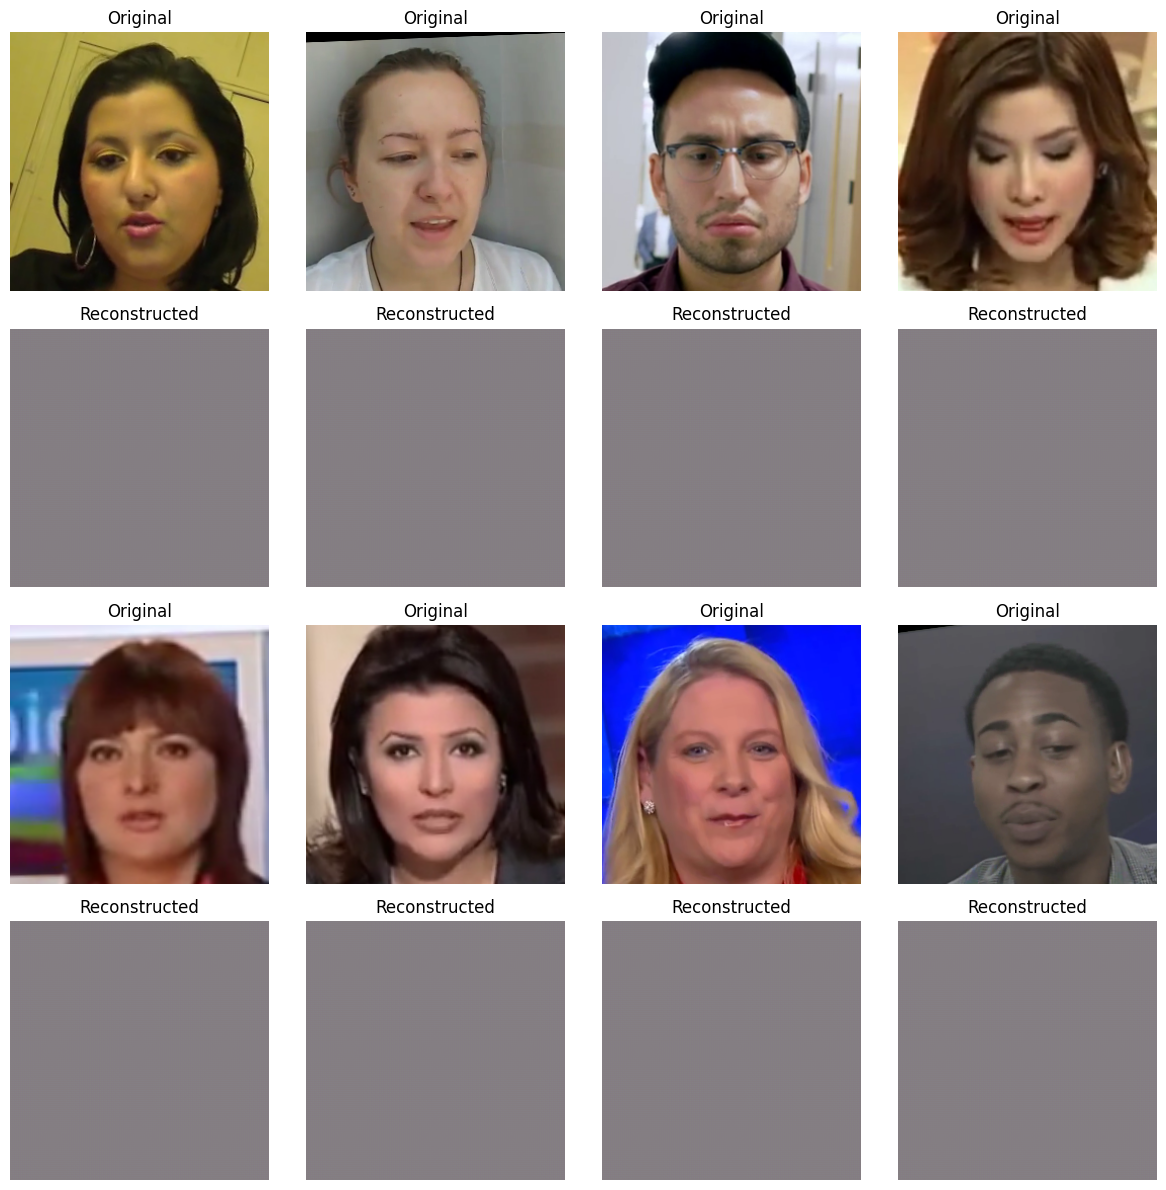

In [47]:
visualize_reconstruction(model, data_loader, device)

In [48]:
# Training
lambda_l1 = 1e-5
epochs = 20
train_autoencoder(data_loader, model, criterion, optimizer, epochs, device, lambda_l1)

Training Epoch 1/20:   0%|          | 0/1335 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 563.12 MiB is free. Process 3091 has 15.34 GiB memory in use. Of the allocated memory 14.70 GiB is allocated by PyTorch, and 340.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)